# Library

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils

import time
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data load & preprocessing

In [29]:
transform = transforms.Compose([
            # 가운데 부분을 28x28로 자른다 내 생각엔 안해도 될듯?
            transforms.Resize(28),
            transforms.ToTensor(),
            transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])
dataset = datasets.CIFAR10('./dataset', train='train',
                                download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=128,
                                         shuffle=True, num_workers=4)

Files already downloaded and verified


# Model Define

In [30]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.tconv1 = nn.ConvTranspose2d(74, 1024, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(1024)

        self.tconv2 = nn.ConvTranspose2d(1024, 128, 7, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)

        self.tconv3 = nn.ConvTranspose2d(128, 64, 4, 2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)

        self.tconv4 = nn.ConvTranspose2d(64, 3, 4, 2, padding=1, bias=False)

    def forward(self, x):
        x = F.relu(self.bn1(self.tconv1(x)))
        x = F.relu(self.bn2(self.tconv2(x)))
        x = F.relu(self.bn3(self.tconv3(x)))

        img = torch.sigmoid(self.tconv4(x))

        return img # (1,28,28) 짜리 fake 생성

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1)

        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 1024, 7, bias=False)
        self.bn3 = nn.BatchNorm2d(1024)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.1, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.1, inplace=True)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.1, inplace=True)

        return x # (1024,1,1) 짜리 텐서 생성

class DHead(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Conv2d(1024, 1, 1)

    def forward(self, x):
        output = torch.sigmoid(self.conv(x))

        return output # 받은 텐서로 fake/real 일 확률 반환

class QHead(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1024, 128, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(128)

        self.conv_disc = nn.Conv2d(128, 10, 1)
        self.conv_mu = nn.Conv2d(128, 2, 1)
        self.conv_var = nn.Conv2d(128, 2, 1)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.1, inplace=True)

        disc_logits = self.conv_disc(x).squeeze() # (10,) 짜리 텐서 0~9 숫자 타입(c_1)에 대한 이산형 변수

        mu = self.conv_mu(x).squeeze()               # (2,) 짜리 c_2,c_3의 평균에 해당하는 변수
        var = torch.exp(self.conv_var(x).squeeze())  # (2,) 짜리 c_2,c_3의 분산에 해당하는 변수

        return disc_logits, mu, var

# Function Define

In [31]:
def weights_init(m):
    """
    Initialise weights of the model.
    """
    if(type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02) # convolutional layer 의 weight을 N(0,0.02)로 초기화
    elif(type(m) == nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02) # BN layer 의 weight을 N(1,0.02)로 초기화
        nn.init.constant_(m.bias.data, 0)         # BN layer 의 bias을 0으로 초기화

class NormalNLLLoss: # 손실함수로 사용할거임
    """
    Calculate the negative log likelihood
    of normal distribution.
    This needs to be minimised.
    Treating Q(cj | x) as a factored Gaussian.
    """
    def __call__(self, x, mu, var):

        logli = -0.5 * (var.mul(2 * np.pi) + 1e-6).log() - (x - mu).pow(2).div(var.mul(2.0) + 1e-6)
        nll = -(logli.sum(1).mean())

        return nll # 최우추정량 비슷하게 -log를 이용하여 우도가 최소가 되게해서 c1,c2에 모수를 추정하자

def noise_sample(n_dis_c, dis_c_dim, n_con_c, n_z, batch_size, device):
    """
    Sample random noise vector for training.
    INPUT
    --------
    n_dis_c : Number of discrete latent code.
    dis_c_dim : Dimension of discrete latent code.
    n_con_c : Number of continuous latent code.
    n_z : Dimension of incompressible noise.
    batch_size : Batch Size
    device : GPU/CPU
    """

    idx = np.zeros((n_dis_c, batch_size)) # (1,128) 크기의 0행렬
    if(n_dis_c != 0):
        dis_c = torch.zeros(batch_size, n_dis_c, dis_c_dim, device=device) # (128,1,10) 크기의 0행렬

        for i in range(n_dis_c):
            idx[i] = np.random.randint(dis_c_dim, size=batch_size) # 128칸을 0~9사이의 정수로 채움
            dis_c[torch.arange(0, batch_size), i, idx[i]] = 1.0 # 위에서 만든 idx의 숫자를 dis_c의 숫자에 대응하는 인덱스로 하여 1을 저장

        dis_c = dis_c.view(batch_size, -1, 1, 1) # (128,10,1,1) 크기의 텐서로 변환

    if(n_con_c != 0):
        # Random uniform between -1 and 1.
        con_c = torch.rand(batch_size, n_con_c, 1, 1, device=device) * 2 - 1 # -1~1 사이의 실수로 (128,2,1,1) 생성

    z = torch.randn(batch_size, n_z, 1, 1, device=device) # (128,62,1,1) 사이즈의 정규분포에서 가져온 텐서
    noise = z

    if(n_dis_c != 0):
        noise = torch.cat((z, dis_c), dim=1)
    if(n_con_c != 0):
        noise = torch.cat((noise, con_c), dim=1) # 위에서 만든 dis_c와 con_c를 z에 붙여서 (128,74,1,1) 크기의 input 생성

    return noise, idx

# Parameters

In [32]:
params = {
    'batch_size': 128,# Batch size.
    'num_epochs': 100,# Number of epochs to train for.
    'learning_rate': 2e-4,# Learning rate.
    'beta1': 0.5,
    'beta2': 0.999,
    'save_epoch' : 25,# After how many epochs to save checkpoints and generate test output.
    'dataset' : 'MNIST'}

if(params['dataset'] == 'MNIST'):
    params['num_z'] = 62
    params['num_dis_c'] = 1
    params['dis_c_dim'] = 10
    params['num_con_c'] = 2

# Train

In [33]:
# device 설정
device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")

# 모델 설정
netG = Generator().to(device)
netG.apply(weights_init)

discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

netD = DHead().to(device)
netD.apply(weights_init)

netQ = QHead().to(device)
netQ.apply(weights_init)

# Loss for discrimination between real and fake images.
criterionD = nn.BCELoss()
# Loss for discrete latent code.
criterionQ_dis = nn.CrossEntropyLoss()
# Loss for continuous latent code.
criterionQ_con = NormalNLLLoss()
# Adam optimizer
optimD = torch.optim.Adam([{'params': discriminator.parameters()}, {'params': netD.parameters()}],
                          lr=params['learning_rate'], betas=(params['beta1'], params['beta2']))
optimG = torch.optim.Adam([{'params': netG.parameters()}, {'params': netQ.parameters()}],
                          lr=params['learning_rate'], betas=(params['beta1'], params['beta2']))

# 나중에 성능 체크를 위해 Fixed Noise를 정의 위의 noise_sample이랑 비슷함
z = torch.randn(100, params['num_z'], 1, 1, device=device)
fixed_noise = z
if(params['num_dis_c'] != 0):
    idx = np.arange(params['dis_c_dim']).repeat(10)
    dis_c = torch.zeros(100, params['num_dis_c'], params['dis_c_dim'], device=device)
    for i in range(params['num_dis_c']):
        dis_c[torch.arange(0, 100), i, idx] = 1.0

    dis_c = dis_c.view(100, -1, 1, 1)

    fixed_noise = torch.cat((fixed_noise, dis_c), dim=1)

if(params['num_con_c'] != 0):
    con_c = torch.rand(100, params['num_con_c'], 1, 1, device=device) * 2 - 1
    fixed_noise = torch.cat((fixed_noise, con_c), dim=1)

# label 설정
real_label = 1.0
fake_label = 0.0

# List variables to store results pf training.
img_list = []
G_losses = []
D_losses = []

In [34]:
start_time = time.time()
iters = 0
data_1=0
for epoch in range(100):
    epoch_start_time = time.time()

    for i, (data, _) in enumerate(dataloader, 0):
        data_1=data
        # Get batch size
        b_size = data.size(0)
        # Transfer data tensor to GPU/CPU (device)
        real_data = data.to(device)

        # Updating discriminator and DHead
        optimD.zero_grad()
        # Real data
        label = torch.full((b_size, ), real_label, device=device) # 1.0 으로 채워진 (128,)크기의 label 생성
        output1 = discriminator(real_data)
        probs_real = netD(output1).view(-1) # 나온 확률을 1차원 배열로 만듬 (128,)

        loss_real = criterionD(probs_real, label) # 실제값 1.0과 이진 크로스 엔트로피를 구함
        # Calculate gradients.
        loss_real.backward() # 오차역전파로 기울기 계산하여 저장

        # Fake data
        label.fill_(fake_label) # 위의 label 과 똑같은 크기의 0.0로 채워진 fake_label 생성
        noise, idx = noise_sample(params['num_dis_c'], params['dis_c_dim'], params['num_con_c'], params['num_z'], b_size, device)
        fake_data = netG(noise)
        output2 = discriminator(fake_data.detach()) # fake_data를 기울기 전파가 안되는 텐서로 복사함
        probs_fake = netD(output2).view(-1)
        loss_fake = criterionD(probs_fake, label) # 실제값 0.0과 이진 크로스 엔트로피를 구함
        # Calculate gradients.
        loss_fake.backward() # 오차역전파로 기울기 계산하여 저장
        # Net Loss for the discriminator
        D_loss = loss_real + loss_fake # 구한 loss의 합을 산출
        # Update parameters
        optimD.step() # discriminator와 netD 업데이트

         # Updating Generator and QHead
        optimG.zero_grad()
        # Fake data treated as real.
        output = discriminator(fake_data)
        label.fill_(real_label)
        probs_fake = netD(output).view(-1)
        gen_loss = criterionD(probs_fake, label) # 생성자의 loss 계산

        q_logits, q_mu, q_var = netQ(output) # fake img 에 대하여 계산한 code의 모수를 추정
        target = torch.LongTensor(idx).to(device) # noise_sample에서 만든 idx를 실수형 텐서로 변환

        # Calculating loss for discrete latent code.
        dis_loss = 0
        for j in range(params['num_dis_c']):
            dis_loss += criterionQ_dis(q_logits[:, j*10 : j*10 + 10], target[j]) # 아직 잘 모르겠음

        # Calculating loss for continuous latent code.
        con_loss = 0 # 이것도 잘모르겠음..
        if (params['num_con_c'] != 0):
            con_loss = criterionQ_con(noise[:, params['num_z']+ params['num_dis_c']*params['dis_c_dim'] : ].view(-1, params['num_con_c']), q_mu, q_var)*0.1

        # Net loss for generator.
        G_loss = gen_loss + dis_loss + con_loss
        # Calculate gradients.
        G_loss.backward()
        # Update parameters.
        optimG.step()

    epoch_time = time.time() - epoch_start_time
    print("Time taken for Epoch %d: %.2fs" %(epoch + 1, epoch_time))

     # Generate image after each epoch to check performance of the generator. Used for creating animated gif later.
    with torch.no_grad():
        gen_data = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True))

training_time = time.time() - start_time
print('Training finished!\nTotal Time for Training: %.2fm' %(training_time / 60))

Time taken for Epoch 1: 82.05s
Time taken for Epoch 2: 81.05s
Time taken for Epoch 3: 80.95s
Time taken for Epoch 4: 80.95s
Time taken for Epoch 5: 80.57s
Time taken for Epoch 6: 80.62s
Time taken for Epoch 7: 80.75s
Time taken for Epoch 8: 80.83s
Time taken for Epoch 9: 80.90s
Time taken for Epoch 10: 80.89s
Time taken for Epoch 11: 80.88s
Time taken for Epoch 12: 80.79s
Time taken for Epoch 13: 80.75s
Time taken for Epoch 14: 80.80s
Time taken for Epoch 15: 80.76s
Time taken for Epoch 16: 80.66s
Time taken for Epoch 17: 80.70s
Time taken for Epoch 18: 80.73s
Time taken for Epoch 19: 80.85s
Time taken for Epoch 20: 80.96s
Time taken for Epoch 21: 80.58s
Time taken for Epoch 22: 80.62s
Time taken for Epoch 23: 80.86s
Time taken for Epoch 24: 80.66s
Time taken for Epoch 25: 80.95s
Time taken for Epoch 26: 80.90s
Time taken for Epoch 27: 80.74s
Time taken for Epoch 28: 80.77s
Time taken for Epoch 29: 80.83s
Time taken for Epoch 30: 80.89s
Time taken for Epoch 31: 81.00s
Time taken for Ep

In [35]:
# Save network weights.

torch.save({
    'netG' : netG.state_dict(),
    'discriminator' : discriminator.state_dict(),
    'netD' : netD.state_dict(),
    'netQ' : netQ.state_dict(),
    'optimD' : optimD.state_dict(),
    'optimG' : optimG.state_dict(),
    'params' : params
    }, '/content/drive/MyDrive/Colab Notebooks/코드 이론/GAN/infoGAN_CIFAR10')

In [36]:
# Load the checkpoint file
state_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/코드 이론/GAN/infoGAN_CIFAR10') # GPU

# Set the device to run on: GPU or CPU.
device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
# Get the 'params' dictionary from the loaded state_dict.
params = state_dict['params']

# Create the generator network.
netG = Generator().to(device)
# Load the trained generator weights.
netG.load_state_dict(state_dict['netG'])

<All keys matched successfully>

# latent code 생성

In [37]:
c = np.linspace(-2.5, 2.5, 10).reshape(1, -1)
c = np.repeat(c, 10, 0).reshape(-1, 1)
c = torch.from_numpy(c).float().to(device)
c = c.view(-1, 1, 1, 1)

zeros = torch.zeros(100, 1, 1, 1, device=device)

# Continuous latent code.
c2 = torch.cat((c, zeros), dim=1)
c3 = torch.cat((zeros, c), dim=1)

In [38]:
idx = np.arange(10).repeat(10)
dis_c = torch.zeros(100, 10, 1, 1, device=device)
dis_c[torch.arange(0, 100), idx] = 1.0
# Discrete latent code.
c1 = dis_c.view(100, -1, 1, 1)

In [39]:
# 노이즈 생성
z = torch.randn(100, 62, 1, 1, device=device)

# To see variation along c2 (Horizontally) and c1 (Vertically)
noise1 = torch.cat((z, c1, c2), dim=1)
# To see variation along c3 (Horizontally) and c1 (Vertically)
noise2 = torch.cat((z, c1, c3), dim=1)


## digit type

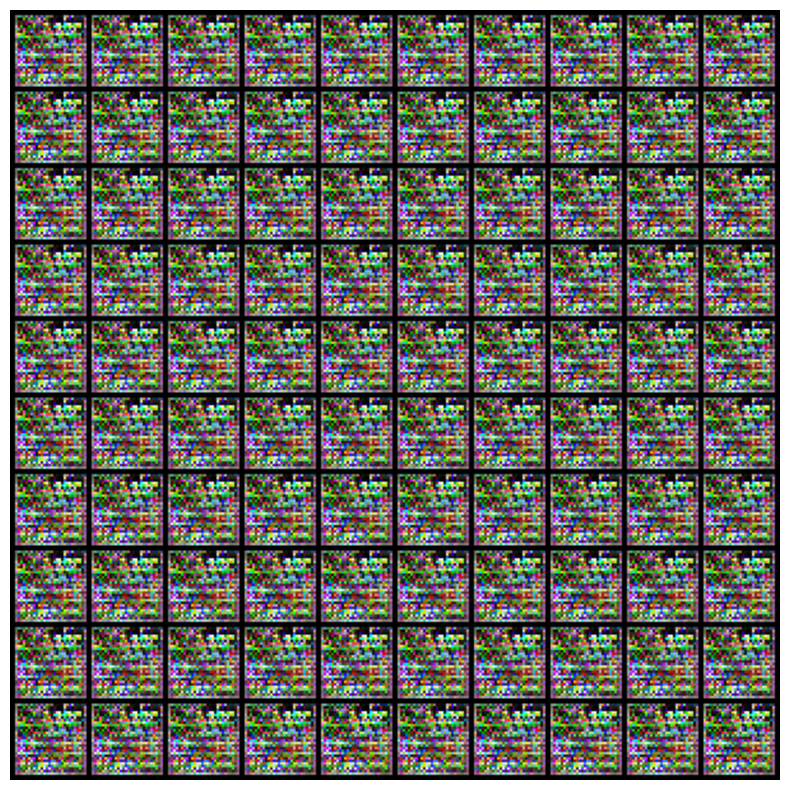

In [40]:
idx = np.array([7,7,7,7,7,7,7,7,7,7,
                4,4,4,4,4,4,4,4,4,4,
                9,9,9,9,9,9,9,9,9,9,
                3,3,3,3,3,3,3,3,3,3,
                0,0,0,0,0,0,0,0,0,0,
                8,8,8,8,8,8,8,8,8,8,
                6,6,6,6,6,6,6,6,6,6,
                5,5,5,5,5,5,5,5,5,5,
                1,1,1,1,1,1,1,1,1,1,
                2,2,2,2,2,2,2,2,2,2])
dis_c = torch.zeros(100, 10, 1, 1, device=device)
dis_c[torch.arange(0, 100), idx] = 1.0
# Discrete latent code.
c1 = dis_c.view(100, -1, 1, 1)
noise3 = torch.cat((z, c1, c2), dim=1)

# Generate image.
with torch.no_grad():
    generated_img3 = netG(noise3).detach().cpu()
# Display the generated image.
fig = plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(generated_img3, nrow=10, padding=2, normalize=True), (1,2,0)))
plt.show()

## rotation

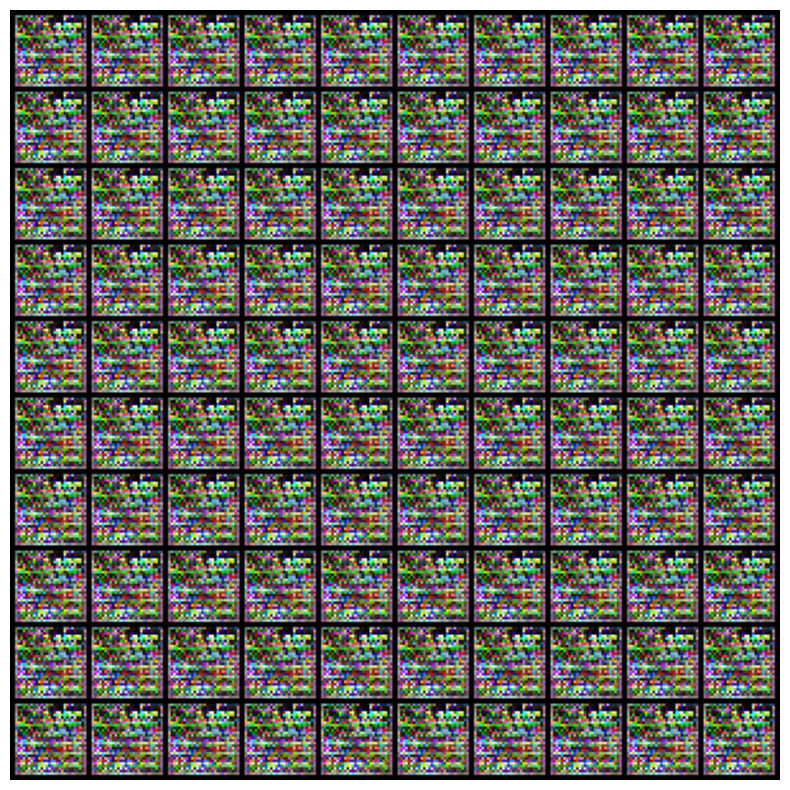

In [41]:
idx = np.array([7,7,7,7,7,7,7,7,7,7,
                4,4,4,4,4,4,4,4,4,4,
                9,9,9,9,9,9,9,9,9,9,
                3,3,3,3,3,3,3,3,3,3,
                0,0,0,0,0,0,0,0,0,0,
                8,8,8,8,8,8,8,8,8,8,
                6,6,6,6,6,6,6,6,6,6,
                5,5,5,5,5,5,5,5,5,5,
                1,1,1,1,1,1,1,1,1,1,
                2,2,2,2,2,2,2,2,2,2])
dis_c = torch.zeros(100, 10, 1, 1, device=device)
dis_c[torch.arange(0, 100), idx] = 1.0
# Discrete latent code.
c1 = dis_c.view(100, -1, 1, 1)
noise3 = torch.cat((z, c1, c2), dim=1)

# Generate image.
with torch.no_grad():
    generated_img3 = netG(noise3).detach().cpu()
# Display the generated image.
fig = plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(generated_img3, nrow=10, padding=2, normalize=True), (1,2,0)))
plt.show()

## width

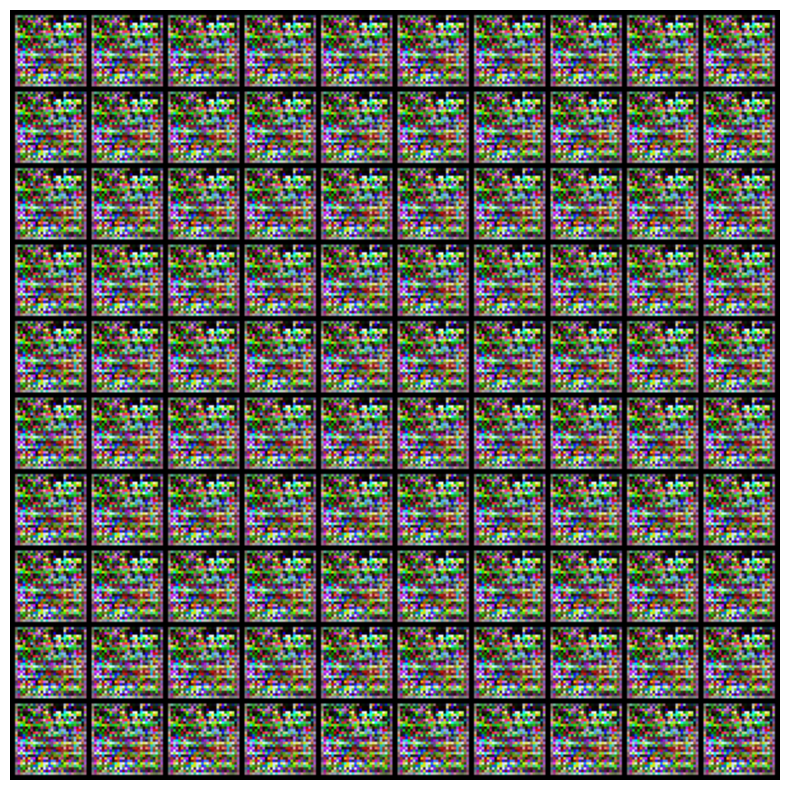

In [42]:
idx = np.array([7,7,7,7,7,7,7,7,7,7,
                4,4,4,4,4,4,4,4,4,4,
                9,9,9,9,9,9,9,9,9,9,
                3,3,3,3,3,3,3,3,3,3,
                0,0,0,0,0,0,0,0,0,0,
                8,8,8,8,8,8,8,8,8,8,
                6,6,6,6,6,6,6,6,6,6,
                5,5,5,5,5,5,5,5,5,5,
                1,1,1,1,1,1,1,1,1,1,
                2,2,2,2,2,2,2,2,2,2])
dis_c = torch.zeros(100, 10, 1, 1, device=device)
dis_c[torch.arange(0, 100), idx] = 1.0
# Discrete latent code.
c1 = dis_c.view(100, -1, 1, 1)
noise3 = torch.cat((z, c1, c3), dim=1)

# Generate image.
with torch.no_grad():
    generated_img3 = netG(noise3).detach().cpu()
# Display the generated image.
fig = plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(generated_img3, nrow=10, padding=2, normalize=True), (1,2,0)))
plt.show()